In [30]:
# avoiding deadlocks

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# importing libraries

from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
import time
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.sentiment import SentimentIntensityAnalyzer
import torch
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer, re, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm as lgb
from langdetect import detect_langs
from googletrans import Translator
import warnings

WEB SCRAPING - amazon.co.uk

In [31]:
# downloading and saving the HTML content using Selenium

def download_html(driver, file_path):
    """
    Downloads the HTML content of the current page using a Selenium WebDriver and saves it to a specified file.

    Parameters:
    driver (selenium.webdriver): The Selenium WebDriver instance used to navigate and interact with the web page.
    file_path (str): The path (including the file name) where the HTML content should be saved.

    Returns:
    None: The function saves the HTML content of the current page to the specified file.
    """
    time.sleep(5)
     
    html_content = driver.page_source
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(html_content)

In [32]:
# extracting reviews

def get_reviews(soup):
    """
    Extracts review details from a BeautifulSoup object representing a webpage containing reviews.

    Parameters:
    soup (BeautifulSoup): A BeautifulSoup object representing the parsed HTML of the webpage.

    Returns:
    list of dict: A list of dictionaries where each dictionary contains details of a review with 
                  keys "title", "body", "rating", and "date".

    Raises:
    SystemExit: If no reviews are found on the page, the function prints a message and exits the program.
    """
    reviews_list = []

    # finding the review elements
    reviews = soup.find_all('div', {'data-hook': 'review'})
    if not reviews:
        print("No reviews found on this page.")
        return reviews_list

    for review in reviews:
        try:
            # review title
            title_element = review.find('a', {'data-hook': 'review-title'})
            title = title_element.text.strip().split("\n")[-1] if title_element else 'No title'
            if title == 'No title':
                title_element = review.find('span', {'data-hook': 'review-title'})
                title = title_element.text.strip().split("\n")[-1] if title_element else 'No title'

            # review body
            body_element = review.find('span', {'data-hook': 'review-body'})
            body = body_element.text.strip() if body_element else 'No body'

            # review rating
            rating_element = review.find('i', {'data-hook': 'review-star-rating'})
            rating = rating_element.text.strip() if rating_element else 'No rating'
            if rating == 'No rating':
                rating_element = review.find('i', {'data-hook': 'cmps-review-star-rating'})
                rating = rating_element.text.strip() if rating_element else 'No rating'

            # review date
            date_element = review.find('span', {'data-hook': 'review-date'})
            date = date_element.text.strip() if date_element else 'No date'

            reviews_list.append({
                "title": title,
                "body": body,
                "rating": rating,
                "date": date
            })
        except AttributeError as e:
            print(f"Error parsing review: {e}")
    
    return reviews_list

In [33]:
# main function to scrape reviews, putting it into a data frame

def scrape(asin):
    """
    Extracts review details from a BeautifulSoup object representing a webpage containing reviews.

    Parameters:
    soup (BeautifulSoup): A BeautifulSoup object representing the parsed HTML of the webpage.

    Returns:
    list of dict: A list of dictionaries where each dictionary contains details of a review with 
                  keys "title", "body", "rating", and "date".

    Raises:
    SystemExit: If no reviews are found on the page, the function prints a message and exits the program.
    """
    html_file_path = 'amazon_reviews.html'
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  
    driver = webdriver.Chrome(options=options)

    dataframe = pd.DataFrame(columns = ["title", "body", "rating", "date"])
    t = []
    b = []
    r = []
    d = []

    try:
        for page_number in range(1,11):
            url = f'https://www.amazon.co.uk/product-reviews/{asin}/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=' + str(page_number)
            driver.get(url)
            download_html(driver, html_file_path)
            with open(html_file_path, 'r', encoding='utf-8') as file:
                html_content = file.read()
            soup = BeautifulSoup(html_content, 'html.parser')
            reviews = get_reviews(soup)
            if not reviews and page_number == 1:  # if no reviews found on the first page => break the loop
                break
            for review in reviews:
                t.append(review["title"])
                b.append(review["body"])
                r.append(review["rating"])
                d.append(review["date"])
            

    finally:
        driver.quit()
    
    dataframe["title"] = t
    dataframe["body"] = b
    dataframe["rating"] = r
    dataframe["date"] = d

    return dataframe

In [34]:
# for UK amazon 

df = scrape(asin = 'B086X5XDD3')


In [35]:
# changing the rating string into an integer representing stars

df["rating"] = df["rating"].apply(lambda x: int(x.split(".")[0]))

# extracting the date from the scraped date info and converting it into a datetime object

df["date"] = df["date"].apply(lambda x: x.split("on")[-1])
df["date"] = pd.to_datetime(df["date"])

In [36]:
# translating non-english reviews to english

def translation(df):
    """
    Translate non-English text reviews in a DataFrame to English using Google Translate.

    This function iterates through a DataFrame containing text reviews, detects the language of each review,
    and translates non-English reviews to English. The translated text replaces the original text in the DataFrame.

    Args:
    - df (DataFrame): A pandas DataFrame containing reviews to be translated. It should have a column named "body" containing text reviews.

    Returns:
    - DataFrame: The modified DataFrame with non-English reviews translated to English. The original "body" column is updated with the translations.

    Prints:
    - A message indicating if a review is empty or too short to process.
    - A message indicating any errors encountered during language detection or translation for specific reviews.

    Notes:
    - Reviews with fewer than 5 characters are considered too short and are not processed for language detection or translation.
    - Handles exceptions during language detection and translation by printing error messages and continuing with the next review.

    """
    translator = Translator()
    for i in range(len(df)):
        review = df.loc[i, "body"]
        if not review or len(review) < 5:  
            print(f"Review at index {i} is empty or too short.")
        
        try:
            lang = str(detect_langs(review)).split(':')[0][1:]
        except Exception as e:
            print(f"Error detecting language for review at index {i}: {e}")
        
        if lang != "en":
            try:
                translation = translator.translate(review, src=lang, dest="en").text
                df.loc[i, "body"] = translation
            except Exception as e:
                print(f"Error translating review at index {i}: {e}")
                
    return df

df = translation(df)
df.head(10)

Review at index 92 is empty or too short.
Error detecting language for review at index 92: No features in text.
Error translating review at index 92: the JSON object must be str, bytes or bytearray, not NoneType


,title,body,rating,date
0,"Very durable inflatable swimming pool, WORTH I...",Buying this swimming pool is one of the best w...,5,2021-05-07
1,Nice,"Bought for grandkids, they love it, it's a goo...",4,2022-08-30
2,Great swimming pool,My son likes this swimming pool. He is 5 years...,5,2021-07-13
3,Extremely disappointing,I purchased this pool a few weeks ago. We only...,1,2021-07-17
4,Easy to put up,"Easy to inflate ,took a few minutes and good s...",5,2023-06-21
5,Great Pool,I bought this pool for my grand kids and is ex...,5,2022-07-17
6,Great pool but empty valve ripped easily,Great sturdy pool easy to inflate with electri...,3,2022-07-31
7,Dreadful quality! The reviews were right,As soon as we opened box it was plain to see t...,2,2022-07-25
8,Summer fun,"Ideal for small gardens, grandkids love it, we...",5,2023-06-26
9,What’s not to like,One day in its built of very sturdy material t...,5,2022-05-07


In [37]:
# saving the dataset

df.to_csv("amazon.csv", index=False)

In [38]:
#RUN ONLY IF YOU DON'T WANT TO SCRAPE AMAZON REVIEWS FOR THE 100th TIME OF THE DAY :))

#df = pd.read_csv("chairs.csv")
#df.head()

SENTIMENT ANALYSIS MODELS

In [39]:
# VADER model

sia = SentimentIntensityAnalyzer()

# predicting the sentiment for each review of the dataset
vader = {}
position = 0
for review in df["body"]:
    vader[position] = {
        "Vnegative": sia.polarity_scores(review)["neg"],
        "Vneutral": sia.polarity_scores(review)["neu"],
        "Vpositive": sia.polarity_scores(review)["pos"],
        "Vcompound": sia.polarity_scores(review)["compound"]
    }
    position += 1

# putting the results into an initial dataframe
df_v = pd.DataFrame(vader).T
df_v = pd.concat([df, df_v], axis = 1)
df_v

,title,body,rating,date,Vnegative,Vneutral,Vpositive,Vcompound
0,"Very durable inflatable swimming pool, WORTH I...",Buying this swimming pool is one of the best w...,5,2021-05-07,0.007,0.784,0.209,0.9906
1,Nice,"Bought for grandkids, they love it, it's a goo...",4,2022-08-30,0.000,0.789,0.211,0.5499
2,Great swimming pool,My son likes this swimming pool. He is 5 years...,5,2021-07-13,0.015,0.795,0.190,0.9867
3,Extremely disappointing,I purchased this pool a few weeks ago. We only...,1,2021-07-17,0.153,0.711,0.135,-0.5170
4,Easy to put up,"Easy to inflate ,took a few minutes and good s...",5,2023-06-21,0.000,0.766,0.234,0.7003
...,...,...,...,...,...,...,...,...
95,Estupenda y buena calidad,"We are very happy with the pool, we are two ad...",5,2022-05-21,0.000,0.762,0.238,0.9040
96,Falsche Maße,The most important argument for this pool was ...,3,2021-06-20,0.254,0.659,0.086,-0.6222
97,Disappointed,Both the original pool and the replacement had...,2,2022-08-17,0.047,0.835,0.118,0.5638
98,disappointed,purchased last year and used a few times and f...,2,2022-07-24,0.052,0.742,0.207,0.8571


In [40]:
# ROBERTA PRETRAINED MODEL (takes context into account)

# surpressing specific FutureWarning from huggingface_hub
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub")

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

# load tokenizer and model (sometimes crashed kernel so had to include try, except)
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    # check if GPU is available and use it, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Model and tokenizer loaded successfully on {device}!")
except Exception as e:
    print(f"An error occurred: {e}")

Model and tokenizer loaded successfully on cpu!


In [41]:
# predicting the sentiment for each review of the dataset

robertamodel = {}
pozice = 0
for review in df["body"]:
    try:
        encoded = tokenizer(review, return_tensors="pt")
        modelled = model(**encoded)
        roberta = modelled[0][0].detach().numpy()
        roberta = softmax(roberta)
        robertamodel[pozice] = {
            "Rnegative": roberta[0],
            "Rneutral": roberta[1],
            "Rpositive": roberta[2]
        }
        pozice += 1
    except RuntimeError:
        print(f"can't process the text in index {pozice}")
        pozice += 1

# concatenating all dataframes together
df_r = pd.DataFrame(robertamodel).T

df_sentiment = pd.concat([df_v, df_r], axis = 1)
df_sentiment.head()


,title,body,rating,date,Vnegative,Vneutral,Vpositive,Vcompound,Rnegative,Rneutral,Rpositive
0,"Very durable inflatable swimming pool, WORTH I...",Buying this swimming pool is one of the best w...,5,2021-05-07,0.007,0.784,0.209,0.9906,0.003782,0.024022,0.972197
1,Nice,"Bought for grandkids, they love it, it's a goo...",4,2022-08-30,0.000,0.789,0.211,0.5499,0.009374,0.046194,0.944432
2,Great swimming pool,My son likes this swimming pool. He is 5 years...,5,2021-07-13,0.015,0.795,0.190,0.9867,0.004507,0.036236,0.959257
3,Extremely disappointing,I purchased this pool a few weeks ago. We only...,1,2021-07-17,0.153,0.711,0.135,-0.5170,0.940514,0.052049,0.007437
4,Easy to put up,"Easy to inflate ,took a few minutes and good s...",5,2023-06-21,0.000,0.766,0.234,0.7003,0.003855,0.120838,0.875307


VISUALISATIONS

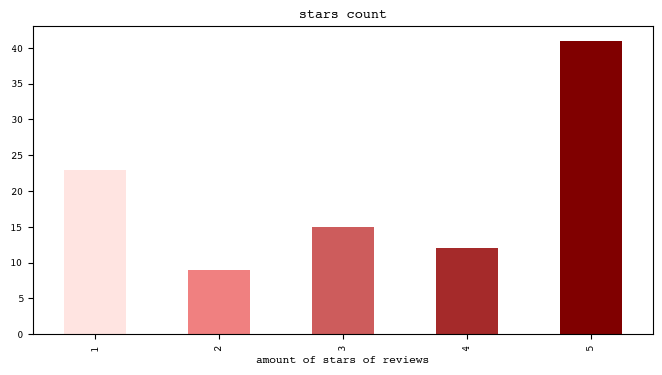

In [42]:
# distribution of stars given to the product

plt.figure(figsize=(10,4))
colors = ["mistyrose", "lightcoral", "indianred", "brown", "maroon"]
ax = df["rating"].value_counts().sort_index().plot.bar(title='stars count', figsize=(8,4), color = colors)
ax.set_xlabel("amount of stars of reviews")
plt.show()

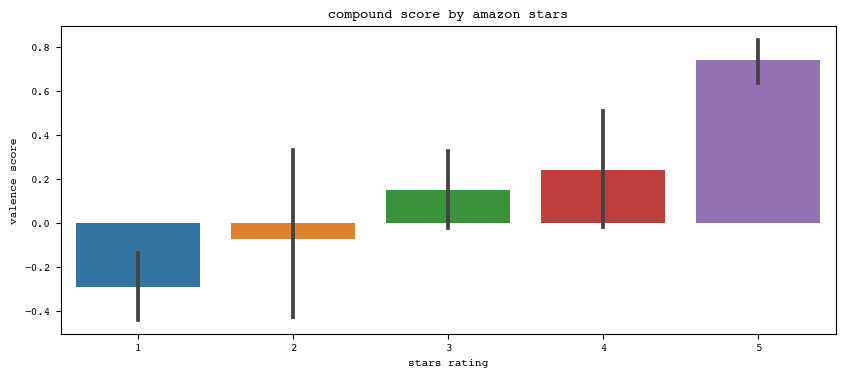

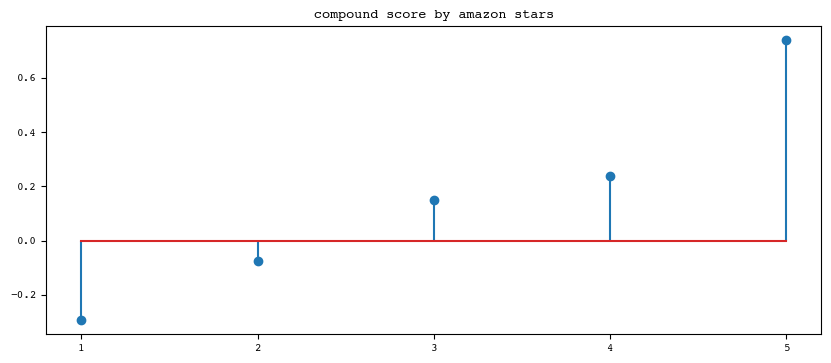

In [43]:
# barplot which shows the average predicted valence (compound score) by VADER model for each "star group"

plt.figure(figsize = (10,4))
ax = sns.barplot(df_v, x = "rating", y = "Vcompound")
ax.set_title("compound score by amazon stars")
ax.set_xlabel("stars rating")
ax.set_ylabel("valence score")
plt.show()

# plot which shows the average predicted valence by VADER model for each "star group" (I assume this one fits better)

meandf = df_sentiment.groupby("rating")["Vcompound"].mean().reset_index()
meandf["rating"] = [str(priemer) for priemer in meandf["rating"]]
plt.figure(figsize=(10,4))
plt.stem(meandf['rating'], meandf['Vcompound'])
plt.title('compound score by amazon stars')
plt.show()

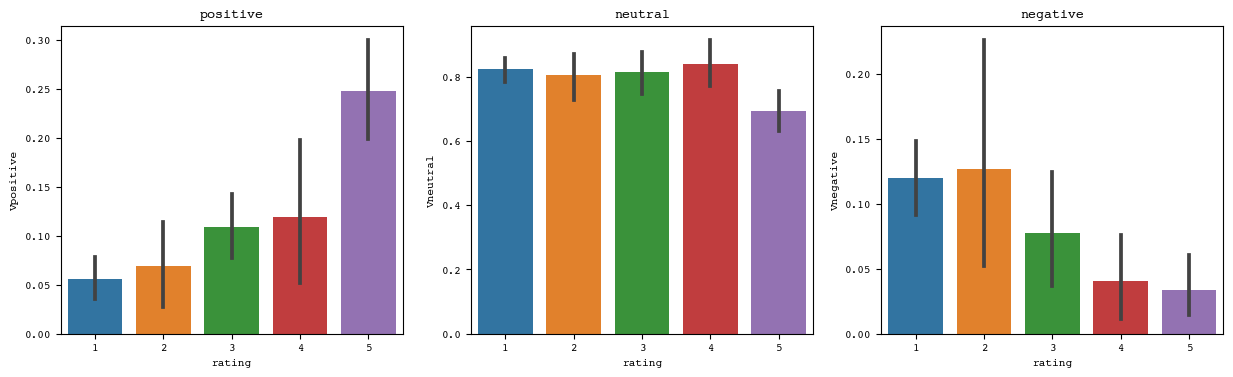

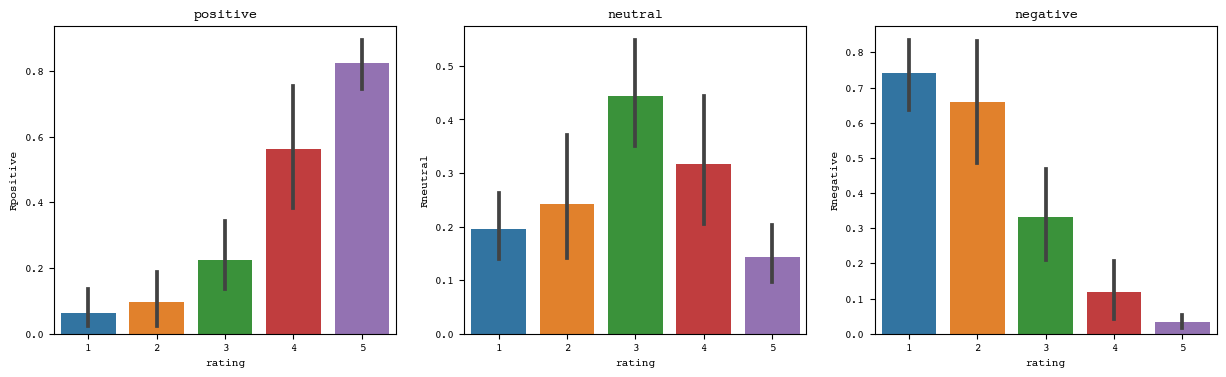

In [44]:
# barplot which displays the average predicted (pos/neu/neg) valence by both models for each "star group"

def pnn_plots(model):
    """
    Generates bar plots for positive, neutral, and negative sentiment scores based on a given model.

    Parameters:
    model (str): The prefix of the column names in the DataFrame `df_sentiment` that contains 
                 sentiment scores. For example, if `model` is "model1", the DataFrame should 
                 contain columns named "model1positive", "model1neutral", and "model1negative".

    Returns:
    None: The function creates and displays a figure with three bar plots. The plots show the 
          sentiment scores (positive, neutral, and negative) against the ratings.
    """
    fig, axs = plt.subplots(1,3, figsize = (15,4))
    sns.barplot(df_sentiment, x = "rating", y = f"{model}positive", ax = axs[0])
    sns.barplot(df_sentiment, x = "rating", y = f"{model}neutral", ax = axs[1])
    sns.barplot(df_sentiment, x = "rating", y = f"{model}negative", ax = axs[2])
    axs[0].set_title("positive")
    axs[1].set_title("neutral")
    axs[2].set_title("negative")

pnn_plots("V")
pnn_plots("R")

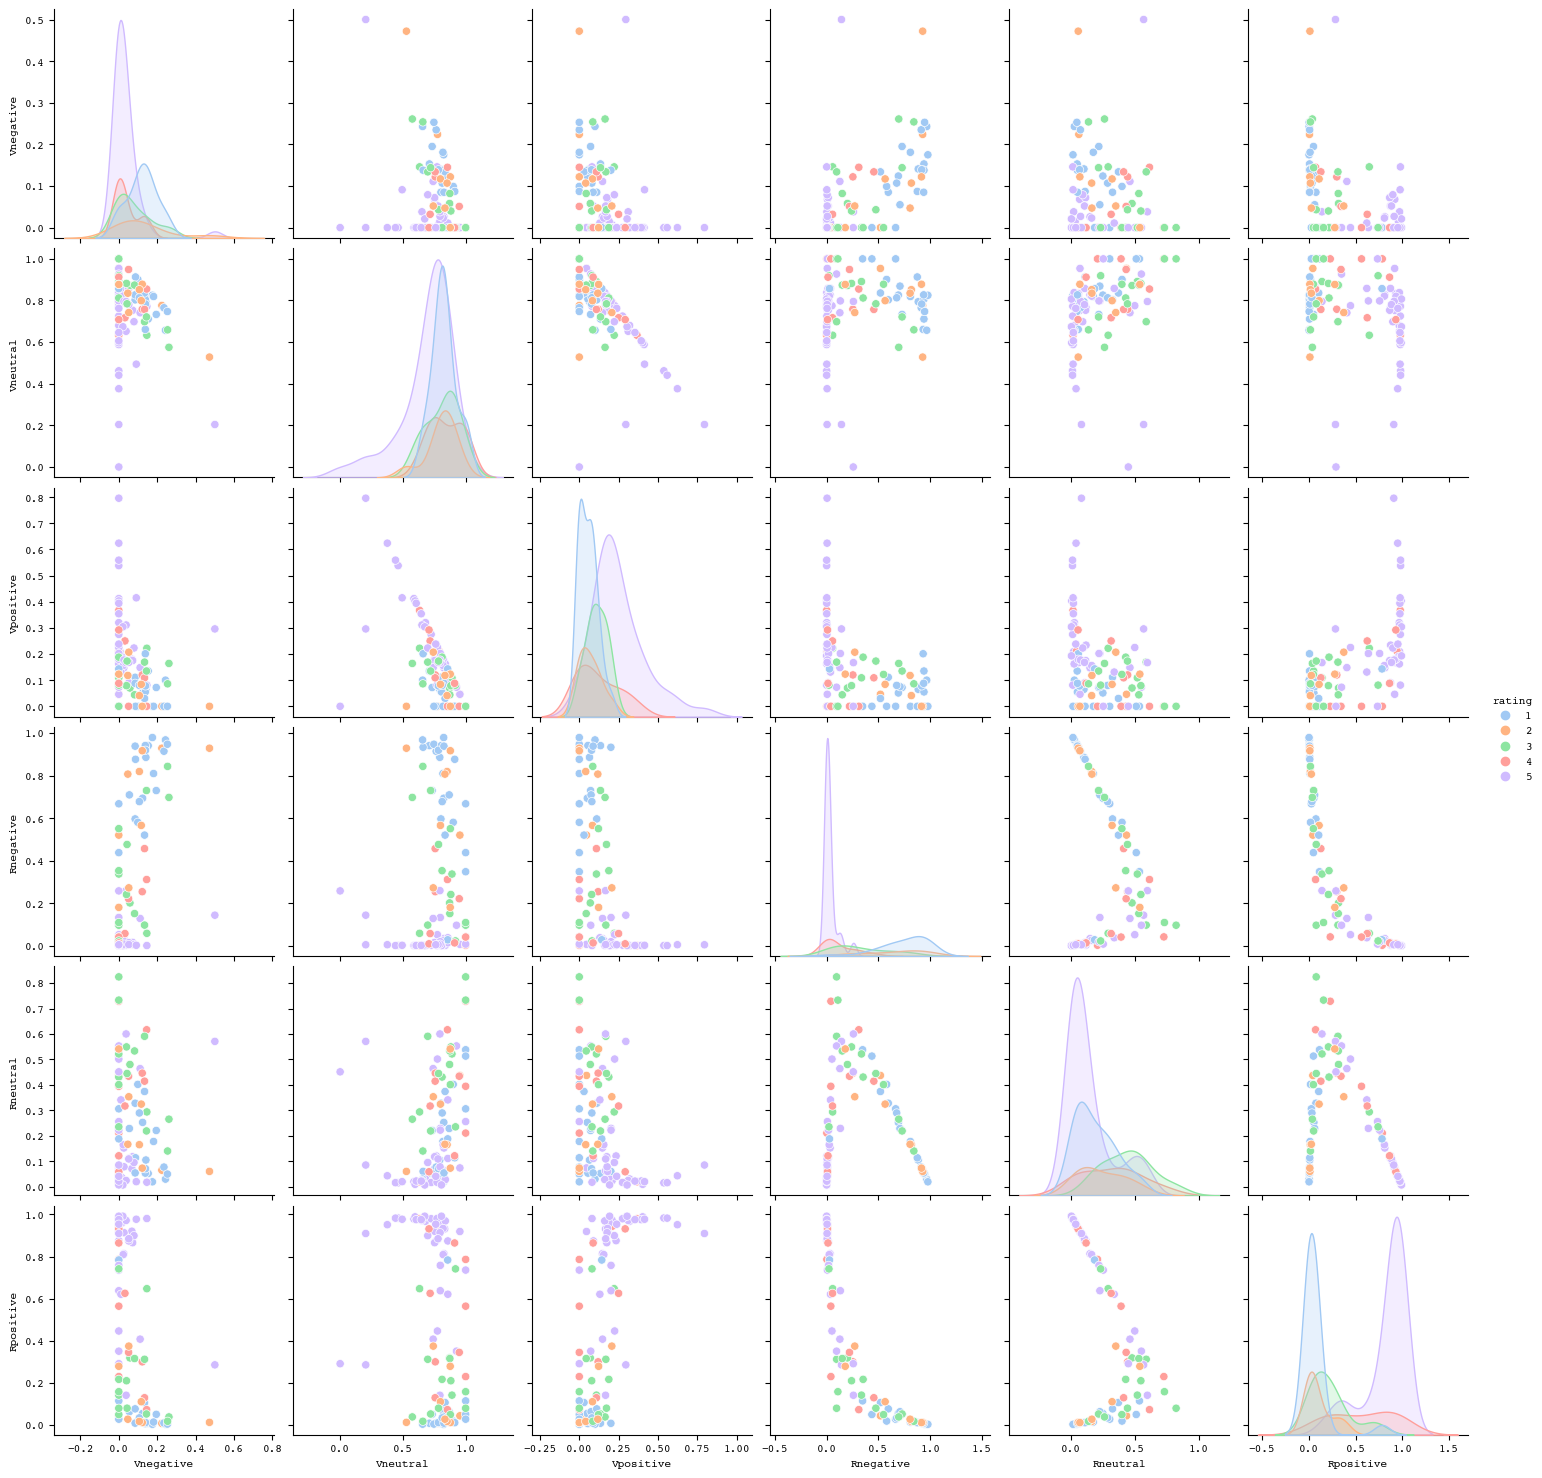

In [45]:
# displaying the relationship between models' predicted sentiments

# surpressing the layout warning as the layout of the graph looks alright
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")

sns.pairplot(data = df_sentiment, vars= ['Vnegative', 'Vneutral', 'Vpositive'
                                       ,'Rnegative', 'Rneutral', 'Rpositive'],
                hue = "rating",
                palette="pastel")
plt.show()

USEFUL FOR CUSTOMER

Text(0.5, 1.0, 'overall sentiment predicted by the VADER model throughout time')

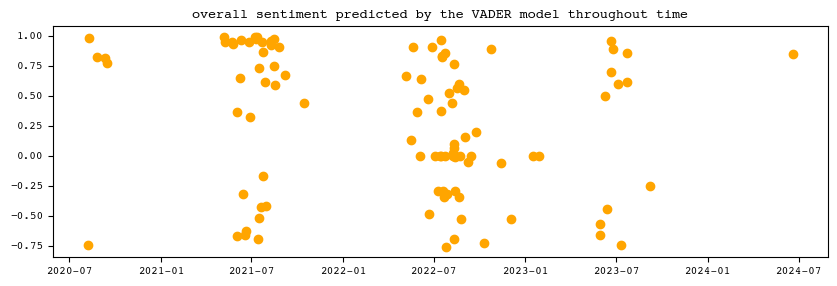

In [46]:
# VADER compound sentiment shown over time

plt.figure(figsize = (10,3))
plt.rc('font', family='Courier', size=8)
plt.scatter(x = df_sentiment["date"], y = df_sentiment["Vcompound"], color = "orange")
plt.title("overall sentiment predicted by the VADER model throughout time")


Text(0.5, 1.0, 'negative sentiment predicted by the roberta model throught time')

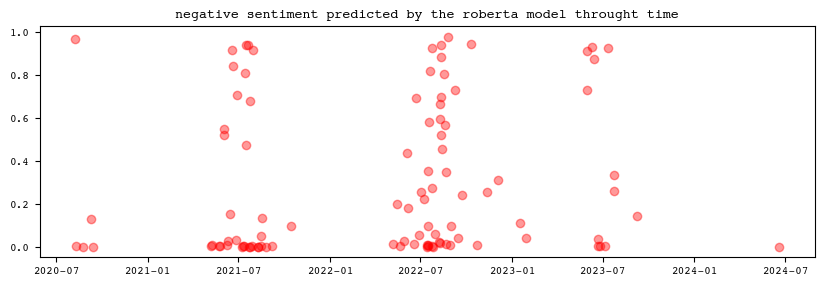

In [47]:
# roBERTa negative sentiment shown over time

plt.figure(figsize=(10,3))
plt.scatter(x = df_sentiment["date"], y = df_sentiment["Rnegative"], color = "red", alpha = 0.4)
plt.title("negative sentiment predicted by the roberta model throught time")

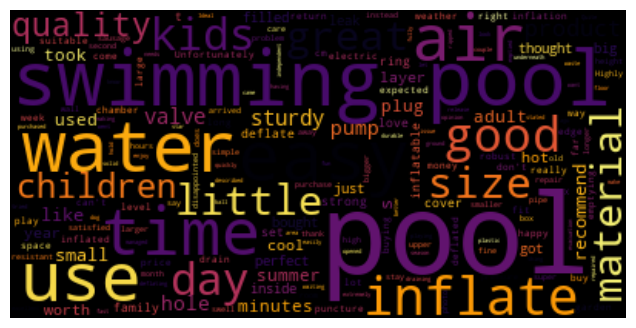

In [48]:
# word cloud displaying the most used words in all of the reviews

reviews = "".join(i for i in df_sentiment["body"])
cloud = WordCloud(stopwords = ENGLISH_STOP_WORDS, colormap="inferno_r").generate(reviews)
plt.figure(figsize=(8,4))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
# descriptive statistics of our results

df_sentiment[["rating", "Vpositive", "Vneutral", "Vnegative", "Vcompound", "Rpositive", "Rneutral", "Rnegative"]].describe()

,rating,Vpositive,Vneutral,Vnegative,Vcompound,Rpositive,Rneutral,Rnegative
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.390000,0.151470,0.769210,0.069310,0.279580,0.462363,0.230537,0.307099
std,1.626144,0.147497,0.170159,0.094293,0.577095,0.401724,0.207433,0.352973
min,1.000000,0.000000,0.000000,0.000000,-0.757400,0.002193,0.006879,0.001198
25%,2.000000,0.046000,0.715500,0.000000,-0.261500,0.049433,0.054051,0.006372
50%,4.000000,0.122500,0.795500,0.035000,0.406000,0.331121,0.165030,0.119330
75%,5.000000,0.203250,0.860750,0.122000,0.837075,0.914790,0.401272,0.614087
max,5.000000,0.796000,1.000000,0.500000,0.991700,0.991671,0.824264,0.978498


In [50]:
# displaying the reviews which are evaluated as best/worst by both models

def text(model):
    """
    Prints the best and worst reviews according to the positive sentiment scores of a given model, 
    and optionally the review with the highest overall sentiment for the VADER model.

    Parameters:
    model (str): The prefix of the column names in the DataFrame `df_sentiment` that contains 
                 sentiment scores. For example, if `model` is "model1", the DataFrame should 
                 contain a column named "model1positive".

    Returns:
    None: The function prints the best and worst reviews based on the highest and lowest positive 
          sentiment scores. If the model is "V", it additionally prints the review with the highest 
          overall sentiment based on the "Vcompound" column.
    """
    best = df_sentiment.loc[df_sentiment[f'{model}positive'].idxmax(), "body"]
    worst = df_sentiment.loc[df_sentiment[f'{model}positive'].idxmin(), "body"]
    print(f"The best review according to model {model}: \n {best} \n")
    print(f"The worst review according to model {model}: \n {worst} \n")

    if model == "V":
        highestsentiment = df_sentiment.loc[df_sentiment["Vcompound"].idxmax(), "body"]
        print(f"The review with the highest sentiment according to VADER model: \n {highestsentiment} \n")

text("V")

text("R")

The best review according to model V: 
 It's super 

The worst review according to model V: 
 As soon as we opened box it was plain to see the quality was dreadful, no hesitation in sending back.The size was not as described either.Avoid at all costs! 

The review with the highest sentiment according to VADER model: 
 Love this pool! perfect size and extremely easy to inflate got it done within minutes of using my air pump (which is not included). love the size and it met my family's needs. The pool is spacious and good to fit in 3 toddlers and their tons of their toys. Pool is made of good material and very sturdy and solid. Highly recommend this pool to anyone who needs to cool off this summer and glad it was available and the price was more than fair! In general, it is fantastic for the summertime and the kids had really great time playing in it. Also, it can be placed indoor (without filling in water) during winter, and kids can still play inside it for fun. 

The best review accor

LOGISTIC REGRESSION -  usually higher accuracy, however not good performance on predicting negative sentiment

In [51]:
def onlyletters(text):
    """
    Removes all punctuation and digits from the input text, leaving only letters and whitespace.

    Parameters:
    text (str): The input string from which to remove punctuation and digits.

    Returns:
    str: The processed string containing only letters and whitespace.
    """
    no_punc = re.sub(r'[^\w\s]', '',text)
    no_digits = ''.join([i for i in no_punc if not i.isdigit()])
    return no_digits

In [52]:
def sentiment(data):
    """
    Processes the input DataFrame to compute sentiment scores based on the rating column.

    This function performs the following steps:
    1. Creates a copy of the input DataFrame to avoid modifying the original data.
    2. Applies the `onlyletters` function to the 'body' column to retain only letter characters.
    3. Sets the 'rating' column to None where the rating is 3.0, marking these rows as neutral.
    4. Drops rows where the 'rating' column is NaN.
    5. Initializes a new column 'sentiment' to 0 (neutral sentiment).
    6. Sets the 'sentiment' column to 1 (positive sentiment) where the rating is 4.0 or 5.0.
    7. Drops rows where the 'sentiment' column is NaN.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing 'body' and 'rating' columns.

    Returns:
    pd.DataFrame: The processed DataFrame with an additional 'sentiment' column.
    """
    data = data.copy()
    data["body"] = data["body"].apply(onlyletters)
    data.loc[(data["rating"] == 3.0), "rating"] = None 
    data = data.dropna(subset="rating")
    data["sentiment"] = 0
    data.loc[(data["rating"] == 5.0) | (data["rating"] == 4.0), "sentiment"] = 1 
    data = data.dropna(subset="sentiment")

    return data

In [53]:
# getting the max features value for tokenization

data = sentiment(data = df)
texts = data["body"] 

# calculating unique tokens

count_vectorizer = CountVectorizer(stop_words="english")
count_vectorizer.fit(texts)
unique_tokens = count_vectorizer.get_feature_names_out()
maxfeatures = min(len(unique_tokens), 1000)

In [54]:
def trainedmodel():
    """
    Trains a logistic regression model on Amazon review data to predict sentiment.

    The function performs the following steps:
    1. Loads the dataset from a CSV file.
    2. Preprocesses the data by converting sentiments to integers and cleaning the text.
    3. Vectorizes the text data using TF-IDF.
    4. Splits the data into training and testing sets.
    5. Trains a logistic regression model on the training data.
    6. Evaluates the model's accuracy on the testing data.

    Returns:
    LogisticRegression: The trained logistic regression model.
    """
    datamazon = pd.read_csv("40kamazonreviews.csv")
    datamazon["sentiment"] = datamazon["sentiment"].apply(lambda x: int(x))
    datamazon["body"] = datamazon["body"].apply(onlyletters)


    # logistic regression model
    vektor = TfidfVectorizer(max_features = maxfeatures, stop_words="english")

    # numpy array of features and label (vector of targets)
    Xko = vektor.fit_transform(datamazon.body)
    yko = datamazon["sentiment"]

    # splitting the dataset into training and testing, building the model
    X_train, X_test, y_train, y_test = train_test_split(Xko,yko, test_size= 0.25, random_state=42)
    log_reg = LogisticRegression().fit(X_train,y_train)

    # evaluating the accuracy of the model using the test part of the dataset
    preds = log_reg.predict(X_test)
    accuracy_score(preds,y_test)

    return log_reg

In [55]:
# predicting the sentiment of our reviews with the logistic regression model

data = sentiment(data = df)
log_reg = trainedmodel()
vektor = TfidfVectorizer(stop_words="english", max_features =maxfeatures)

X = vektor.fit_transform(data.body)
predictLR = log_reg.predict(X)
original = [int(i) for i in data["sentiment"]]

the accuracy is: 0.6235294117647059 

number of accurately predicted sentiments: 53 out of 85 

confusion matrix: 
    negative prediction  positive prediction
0             0.047059             0.329412
1             0.047059             0.576471


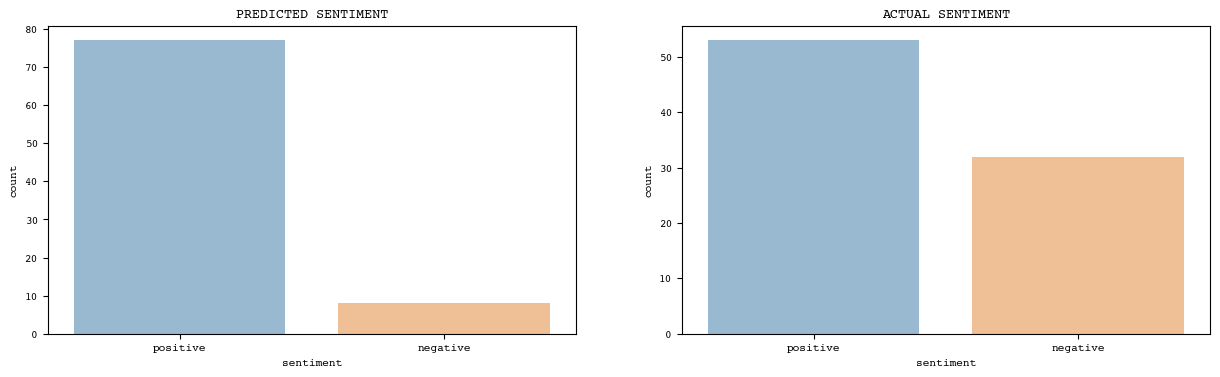

In [56]:
# visualisation of predicted sentiment

def visualise(model):
    """
    Visualizes the predictions of a sentiment analysis model compared to actual sentiments,
    and prints relevant metrics like accuracy and confusion matrix.

    Parameters:
    - model : array-like of shape (n_samples,)
        Predicted sentiment labels from the model. Each entry should be either 0 (negative sentiment)
        or 1 (positive sentiment).

    Outputs:
    - Prints the counts of predicted positive and negative sentiments.
    - Displays bar plots showing predicted and actual sentiment distributions.
    - Prints the accuracy score, number of accurately predicted sentiments, and confusion matrix.
    """
    counterP = 0
    counterN = 0
    for prediction in model:
        if prediction == 1:
            counterP += 1
        elif prediction == 0:
            counterN += 1

    predictions = pd.DataFrame({"sentiment":["positive", "negative"], "count": [counterP, counterN]})
    actual = pd.DataFrame(data.sentiment.value_counts().reset_index())
    actual.loc[actual.sentiment == 0, "sentiment"] = "negative"
    actual.loc[actual.sentiment == 1, "sentiment"] = "positive"

    fig, axs = plt.subplots(1,2, figsize = (15,4))
    sns.barplot(predictions, x = "sentiment", y = "count", alpha = 0.5, ax = axs[0])
    sns.barplot(actual, x = "sentiment", y = "count", alpha = 0.5, ax = axs[1])
    axs[0].set_title("PREDICTED SENTIMENT")
    axs[1].set_title("ACTUAL SENTIMENT")

    print("the accuracy is:", accuracy_score(model, original), "\n")
    print("number of accurately predicted sentiments:", sum(model == original), "out of", len(original), "\n")
    cf = pd.DataFrame(confusion_matrix([int(i) for i in data["sentiment"]], model)/len([int(i) for i in data["sentiment"]]), columns=["negative prediction", "positive prediction"])
    print("confusion matrix: \n", cf)

visualise(predictLR)


LIGHTGBM MODEL - usually better at predicting negative sentiment (but lower accuracy)

In [57]:
# training the lightGBM model

dataset = pd.read_csv("40kamazonreviews.csv")
vectorizer = TfidfVectorizer(stop_words='english', max_features=maxfeatures)
x = vectorizer.fit_transform(dataset["body"])
y = dataset["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

parameters = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0]
}
# LightGBM classifier
lgbclass = lgb.LGBMClassifier(verbosity = -1)

# randomized search = optimizing the hyperparameters of a machine learning model to improve its performance
random_search = RandomizedSearchCV(lgbclass, param_distributions=parameters, n_iter=50, scoring='accuracy', cv=3, verbose=0, random_state=42)
random_search.fit(X_train, y_train)

# getting best model
best_model = random_search.best_estimator_

# evaluating the model
y_pred = best_model.predict(X_test)
print('accuracy of the lightGBM model:', accuracy_score(y_test, y_pred))

accuracy of the lightGBM model: 0.8819572529022458


the accuracy is: 0.611764705882353 

number of accurately predicted sentiments: 52 out of 85 

confusion matrix: 
    negative prediction  positive prediction
0             0.117647             0.258824
1             0.129412             0.494118


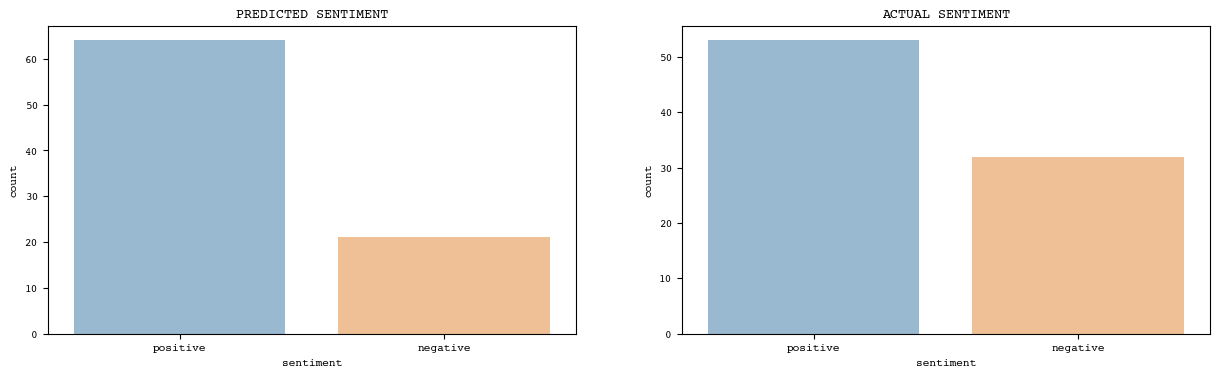

In [58]:
# predicting and visualising the sentiment of our reviews with the lightGBM model

X = vektor.fit_transform(data.body)
predictGBM = best_model.predict(X)
visualise(predictGBM)